In [ ]:
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: google20meet
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification


In [ ]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets,transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
image_path = []
labels = []

for disease_type in os.listdir('/content/eye-diseases-classification/dataset'):
    disease_path = os.path.join('/content/eye-diseases-classification/dataset', disease_type)
    # Check if it's a directory before proceeding
    if os.path.isdir(disease_path):
        for image_file in os.listdir(disease_path):
            image_path.append(os.path.join(disease_path, image_file))
            labels.append(disease_type)

data_df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])
data_df.head()

,image_path,labels
0,/content/eye-diseases-classification/dataset/c...,cataract
1,/content/eye-diseases-classification/dataset/c...,cataract
2,/content/eye-diseases-classification/dataset/c...,cataract
3,/content/eye-diseases-classification/dataset/c...,cataract
4,/content/eye-diseases-classification/dataset/c...,cataract


In [ ]:
data_df['labels'].value_counts()

,count
labels,
diabetic_retinopathy,1098
normal,1074
cataract,1038
glaucoma,1007


In [ ]:
data_df.shape

(4217, 2)

In [ ]:
train=data_df.sample(frac=0.8)
test=data_df.drop(train.index)
train.shape,test.shape

((3374, 2), (843, 2))

In [ ]:
label_encoder=LabelEncoder()

In [ ]:
transformed=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [ ]:
class customImageDataset(Dataset):
  def __init__(self,dataframe,transform=None):
   self.dataframe=dataframe
   self.transform=transform
   self.labels=torch.tensor(label_encoder.fit_transform(dataframe['labels']))

  def __len__(self):
    return self.dataframe.shape[0]
  def __getitem__(self, index):
    img_path=self.dataframe.iloc[index,0]
    label=self.labels[index]
    image=Image.open(img_path).convert('RGB')
    if self.transform:
      image=self.transform(image).to(device)
    return image.to(device),label.to(device)

In [ ]:
train_dataset=customImageDataset(train,transformed)
test_dataset=customImageDataset(test,transformed)

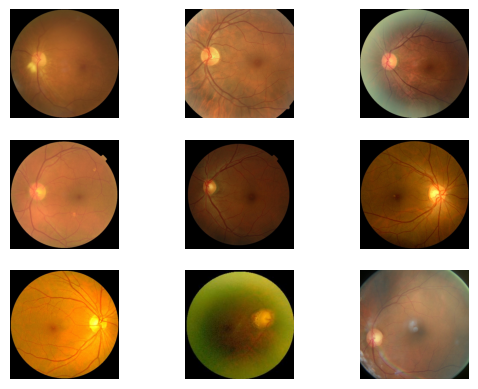

In [ ]:
n_rows=3
n_cols=3
fig, axarr=plt.subplots(n_rows,n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image=Image.open(data_df.sample(n=1)['image_path'].iloc[0]).convert('RGB')
    axarr[row,col].imshow(image)
    axarr[row,col].axis('off')
plt.show()

In [ ]:
train_dataloader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=32,shuffle=False)

In [ ]:
class animal_classification(nn.Module):
  def __init__(self):
    super().__init__()
    self.block1=nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.block2=nn.Sequential(
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.layer=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=256 *32 *32,out_features=len(data_df['labels'].unique()))
    )
  def forward(self,x:torch.tensor):
    return self.layer(self.block2(self.block1(x)))

In [ ]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) # First Convolution layer
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1) # Second Convolution layer
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1) # Third Convolution layer
      self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
      self.relu = nn.ReLU() # ReLU Activation function

      self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
      self.linear = nn.Linear((128 * 16 * 16), 128) # Traditional Dense (Linear)
      self.output = nn.Linear(128, len(data_df['labels'].unique())) # Output Linear Layer


    def forward(self, x):
      x = self.conv1(x) # -> Outputs: (32, 128, 128)
      x = self.pooling(x)# -> Outputs: (32, 64, 64)
      x = self.relu(x)
      x = self.conv2(x) # -> Outputs: (64, 64, 64)
      x = self.pooling(x) # -> Outputs: (64, 32, 32)
      x = self.relu(x)
      x = self.conv3(x) # -> Outputs: (128, 32, 32)
      x = self.pooling(x) # -> Outputs: (128, 16, 16)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

In [ ]:
model=animal_classification().to(device)
#model = Net().to(device)

In [ ]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=1e-4)

In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

EPOCHS=10
for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_dataloader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = loss_fn(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in test_dataloader:
      outputs = model(inputs)
      val_loss = loss_fn(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(test_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/test_dataset.__len__() * 100, 4)}''')
  print("="*25)

Epoch 1/10, Train Loss: 1.1732 Train Accuracy 48.7255
              Validation Loss: 0.2367 Validation Accuracy: 62.7521
Epoch 2/10, Train Loss: 0.8403 Train Accuracy 64.4932
              Validation Loss: 0.2206 Validation Accuracy: 60.7355
Epoch 3/10, Train Loss: 0.728 Train Accuracy 70.0059
              Validation Loss: 0.1837 Validation Accuracy: 70.1068
Epoch 4/10, Train Loss: 0.6653 Train Accuracy 73.5922
              Validation Loss: 0.1843 Validation Accuracy: 69.9881
Epoch 5/10, Train Loss: 0.5976 Train Accuracy 77.0006
              Validation Loss: 0.165 Validation Accuracy: 74.14
Epoch 6/10, Train Loss: 0.5582 Train Accuracy 78.4232
              Validation Loss: 0.154 Validation Accuracy: 78.0546
Epoch 7/10, Train Loss: 0.5077 Train Accuracy 81.1796
              Validation Loss: 0.1507 Validation Accuracy: 77.6987
Epoch 8/10, Train Loss: 0.4796 Train Accuracy 82.217
              Validation Loss: 0.1519 Validation Accuracy: 79.0036
Epoch 9/10, Train Loss: 0.4637 Train A

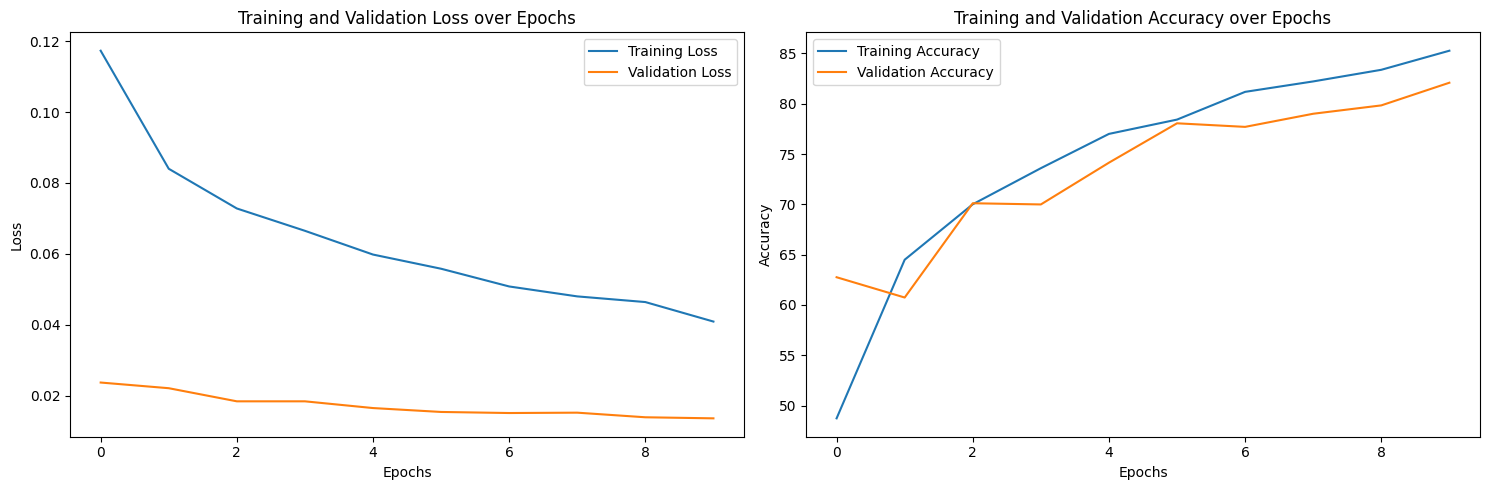

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

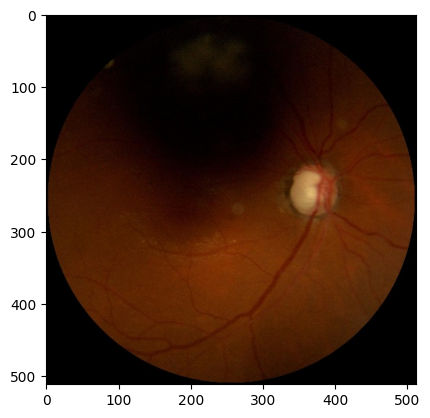


Prediction: 



array(['glaucoma'], dtype=object)

In [ ]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transformed(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/content/eye-diseases-classification/dataset/glaucoma/1209_right.jpg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/content/eye-diseases-classification/dataset/glaucoma/1209_right.jpg")


In [ ]:
PATH = "eye_disease_model_state.pth"
torch.save(model.state_dict(), PATH)
